# Assignment 9 
## Preethi - MM21B051

Task 1:
We import the given dataset and define the baskets. We chose attributes which have few categories in them so that visualisation is easy

In [29]:
import pandas as pd
from PIL import Image
import os

# Load the train.xlsx file
train_df = pd.read_csv("C:/Users/preet/Downloads/visual-taxonomy (copy)/train.csv")

# Load the category_attributes.parquet file
category_attributes = pd.read_parquet("C:/Users/preet/Downloads/visual-taxonomy (copy)/category_attributes.parquet")

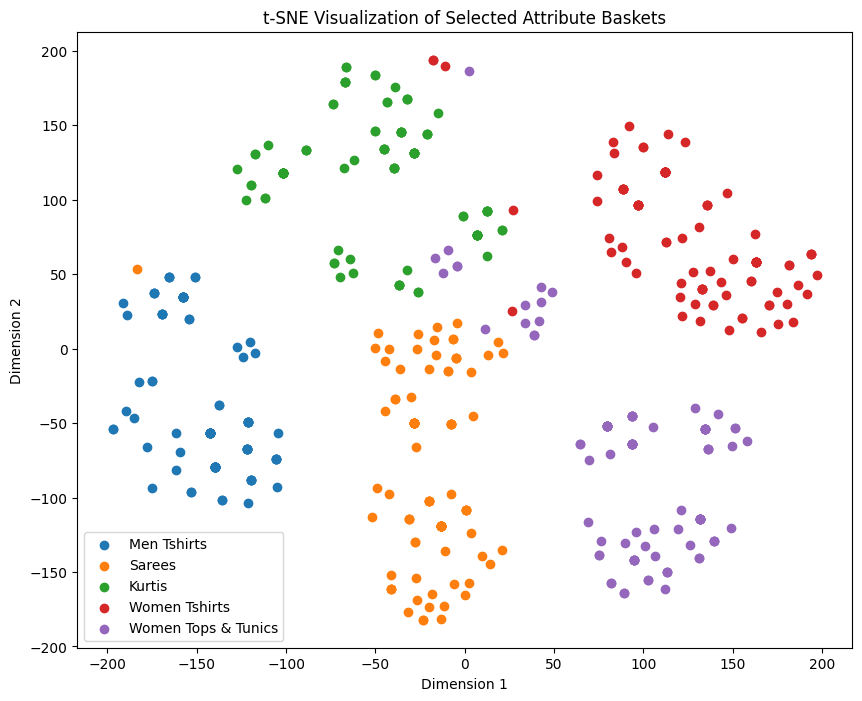

In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define the basket configurations
baskets = {
    "Men Tshirts": ["attr_2", "attr_5"],
    "Sarees": ["attr_3", "attr_5"],
    "Kurtis": ["attr_7", "attr_2"],
    "Women Tshirts": ["attr_6", "attr_7"],
    "Women Tops & Tunics": ["attr_7", "attr_3"]
}

basket_samples = {}
train_df['image_path'] = train_df['id'].apply(lambda x: rf"C:/Users/preet/Downloads/visual-taxonomy (copy)/train_images/{x:06}.jpg")

# Sample 100 items from each basket
for category, attributes in baskets.items():
    filtered_df = train_df[(train_df['Category'] == category) & 
                           (train_df[attributes[0]].notnull()) & 
                           (train_df[attributes[1]].notnull())].copy()
    
    if len(filtered_df) < 100:
        print(f"Basket for {category} with attributes {attributes} has fewer than 100 samples ({len(filtered_df)}). Consider reconfiguring.")
    
    for attr in attributes:
        if filtered_df[attr].dtype == 'object': 
            filtered_df.loc[:, attr] = pd.factorize(filtered_df[attr])[0]  # Convert categories to numbers
    
    basket_samples[f"{category}_{attributes[0]}_{attributes[1]}"] = filtered_df.sample(min(100, len(filtered_df)), random_state=42)

all_samples = pd.concat(basket_samples.values(), ignore_index=True)
for attr in [attr for attrs in baskets.values() for attr in attrs]:
    if all_samples[attr].dtype == 'object':
        all_samples[attr] = pd.factorize(all_samples[attr])[0]

X = all_samples[[attr for attrs in baskets.values() for attr in attrs]].values
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)
# data frame for the t-SNE results
tsne_df = pd.DataFrame(data=X_embedded, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Category'] = all_samples['Category'].values
# lot the t-SNE results
plt.figure(figsize=(10, 8))
for category in tsne_df['Category'].unique():
    plt.scatter(tsne_df[tsne_df['Category'] == category]['Dimension 1'],
                tsne_df[tsne_df['Category'] == category]['Dimension 2'],
                label=category)
    
plt.title('t-SNE Visualization of Selected Attribute Baskets')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


Task 2:
We now plot Isomap and TSNE for each attribute in each basket. We start with defining some functions for plotting.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap, TSNE
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import cm, colors as mcolors

# ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# extract features from image using ResNet50
def extract_image_features(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = resnet_model.predict(img_array)
    return features.flatten()

# creating a color map for values in each attribute
def create_color_map(labels):
    unique_labels = labels.unique()
    cmap = cm.get_cmap('viridis', len(unique_labels))  
    label_color_mapping = {label: mcolors.to_hex(cmap(i)) for i, label in enumerate(unique_labels)}
    return label_color_mapping

# plotting subplots
def plot_embedding_with_images(data, image_paths, labels, title, method):
    label_color_mapping = create_color_map(labels)

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.patch.set_facecolor('#f7f7f7')  
    
    # Subplot 1: 
    ax1 = axes[0]
    ax1.set_facecolor('#e0e0e0')  
    ax1.scatter(data[:, 0], data[:, 1], alpha=0.6, s=10, c='lightblue')  
    for i, (x, y) in enumerate(data):
        image = load_img(image_paths[i], target_size=(32, 32))
        image_array = img_to_array(image) / 255.0
        im = OffsetImage(image_array, zoom=0.5)
        ab = AnnotationBbox(im, (x, y), frameon=False)
        ax1.add_artist(ab)
    ax1.set_title(f"{method} with Image Overlay: {title}", fontsize=14, color='#333333')
    ax1.set_xlabel('Component 1', fontsize=12)
    ax1.set_ylabel('Component 2', fontsize=12)

    # Subplot 2: 
    ax2 = axes[1]
    ax2.set_facecolor('#ffe6f2')  
    for i, (x, y) in enumerate(data):
        ax2.scatter(x, y, color=label_color_mapping[labels.iloc[i]], s=50, alpha=0.8)
    for label, color in label_color_mapping.items():
        ax2.scatter([], [], color=color, label=label, s=50)  
    ax2.legend(title='Attribute Labels', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, facecolor='#ffffff')
    ax2.set_title(f"{method} with Colored Points: {title}", fontsize=14, color='#333333')
    ax2.set_xlabel('Component 1', fontsize=12)
    ax2.set_ylabel('Component 2', fontsize=12)

    plt.tight_layout()
    plt.show()


['Men Tshirts', 'attr', '2', 'attr', '5']
Processing basket: (Men Tshirts, attr_2, attr_5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

C:\Users\preet\AppData\Local\Temp\ipykernel_29732\857486119.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(unique_labels))  # Use 'viridis' colormap for better color contrast


C:\Users\preet\AppData\Local\Temp\ipykernel_29732\857486119.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(unique_labels))  # Use 'viridis' colormap for better color contrast


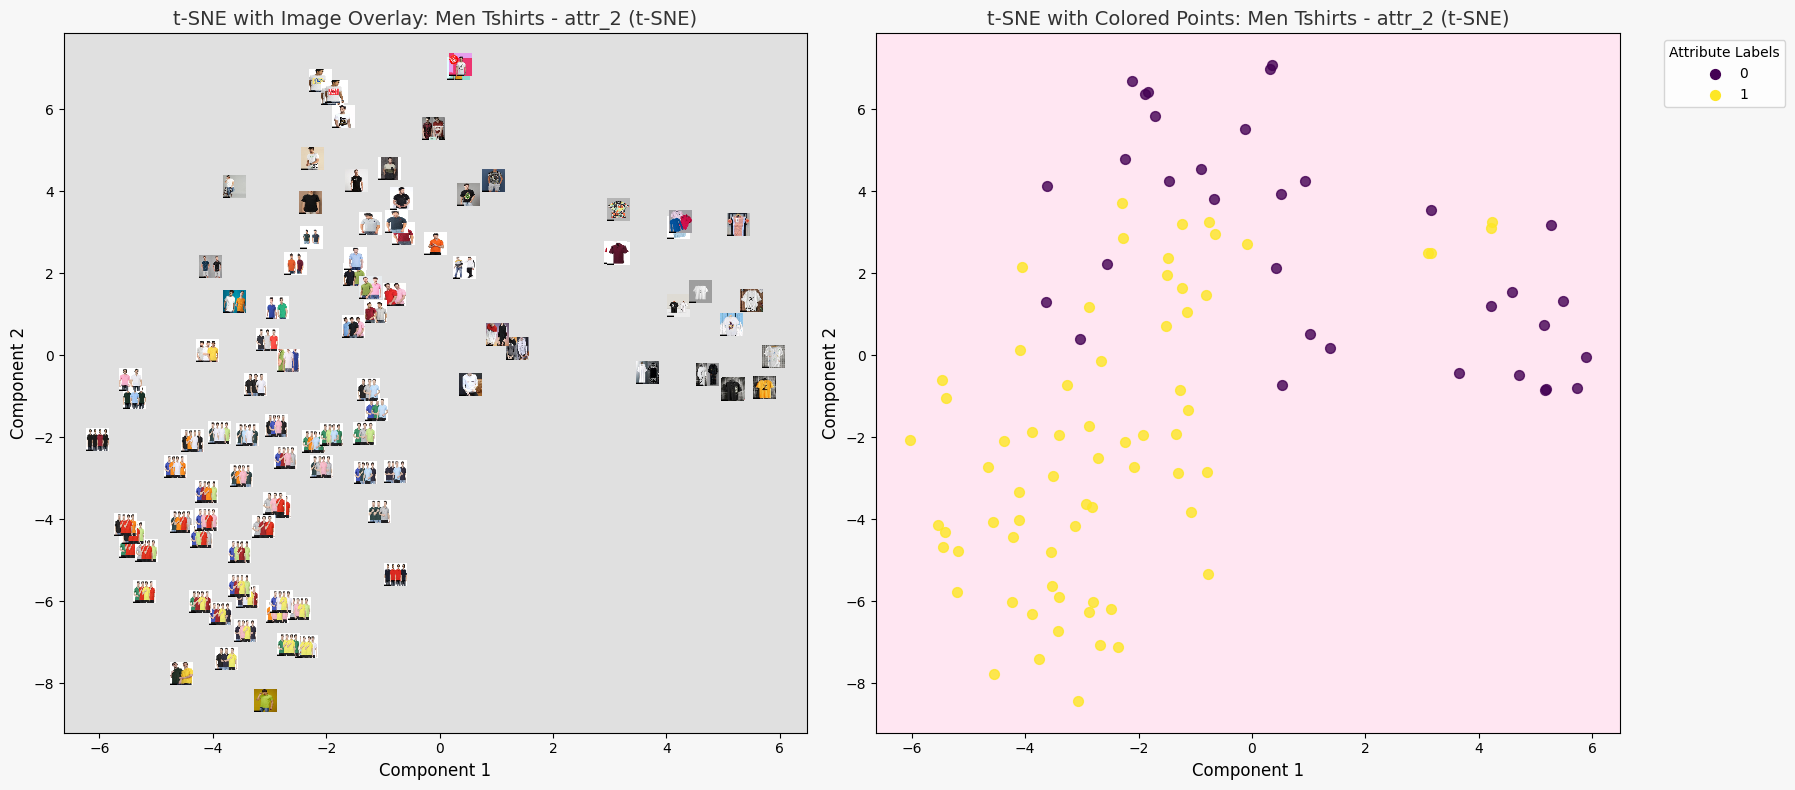

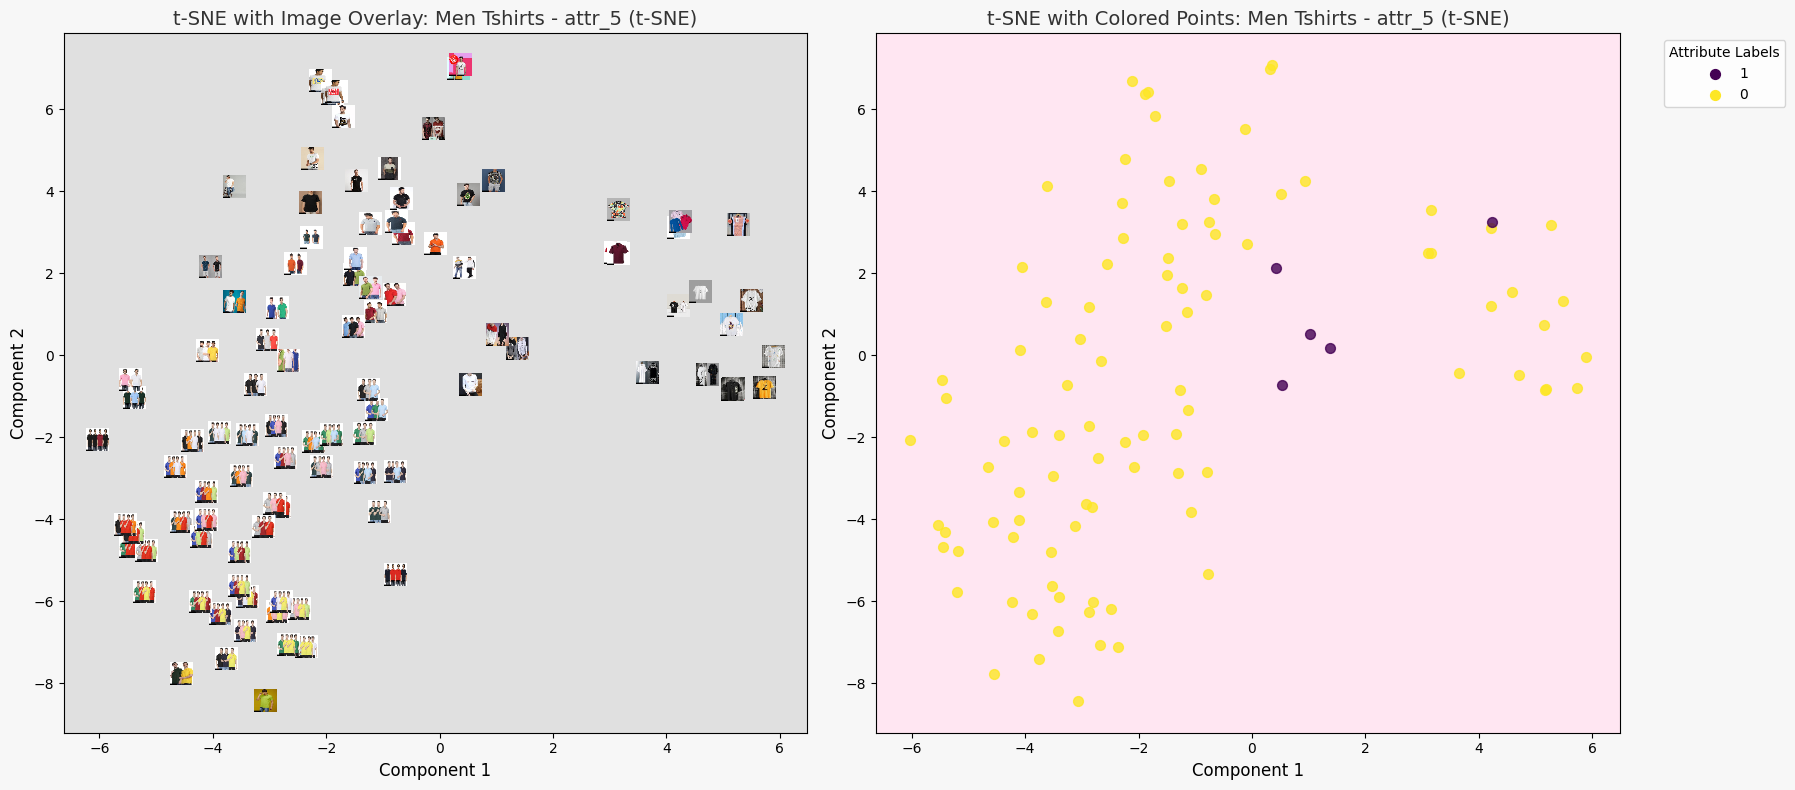

['Sarees', 'attr', '3', 'attr', '5']
Processing basket: (Sarees, attr_3, attr_5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

C:\Users\preet\AppData\Local\Temp\ipykernel_29732\857486119.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(unique_labels))  # Use 'viridis' colormap for better color contrast


C:\Users\preet\AppData\Local\Temp\ipykernel_29732\857486119.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(unique_labels))  # Use 'viridis' colormap for better color contrast


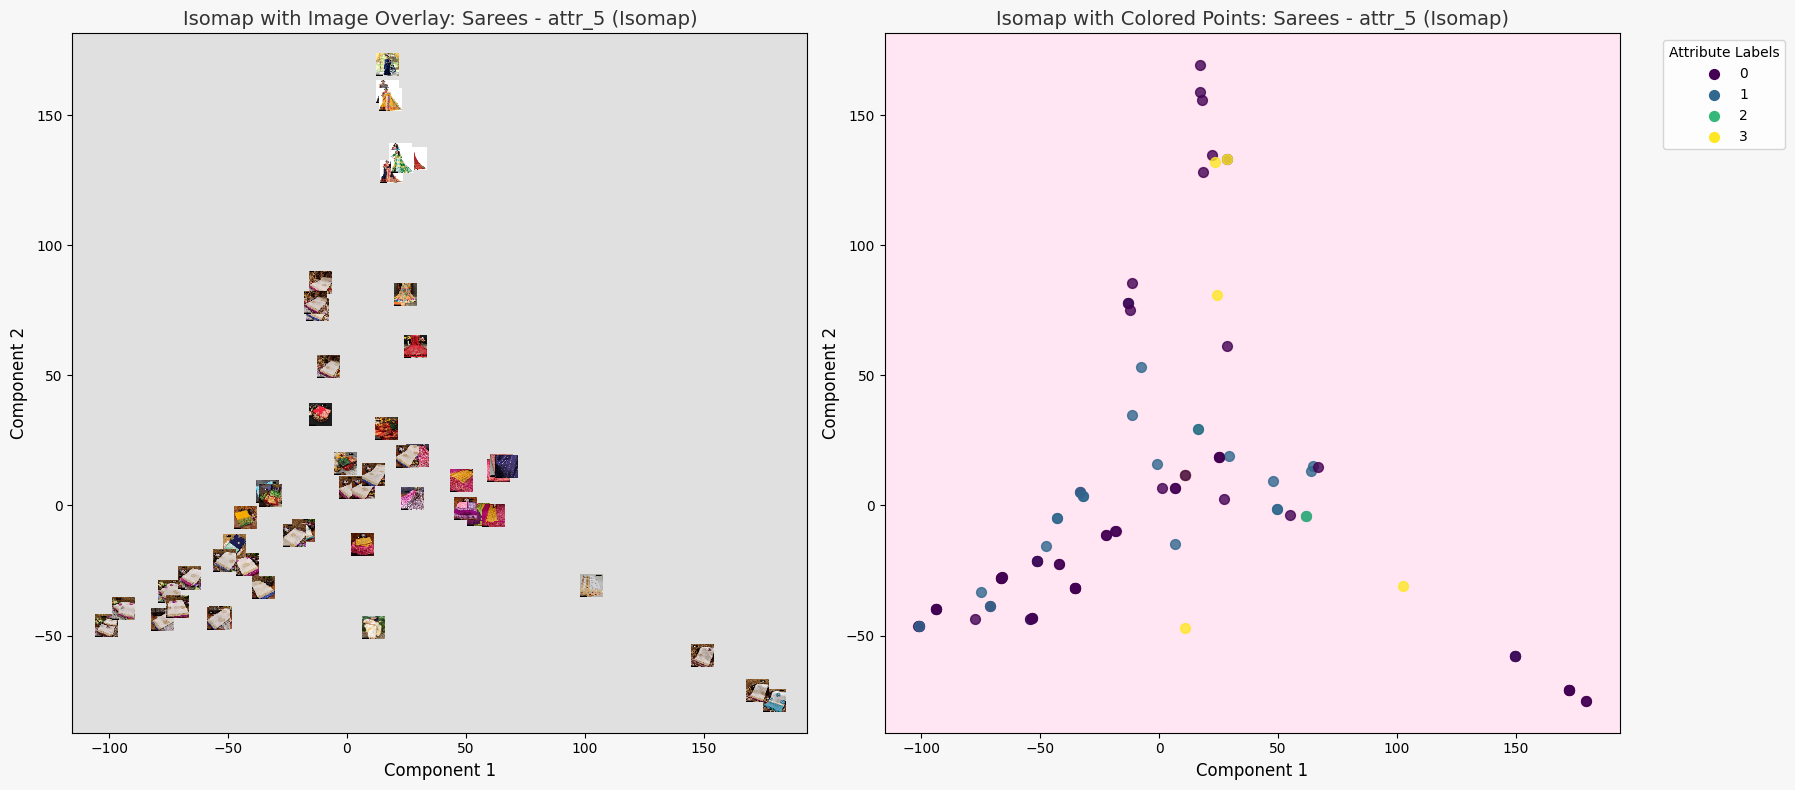

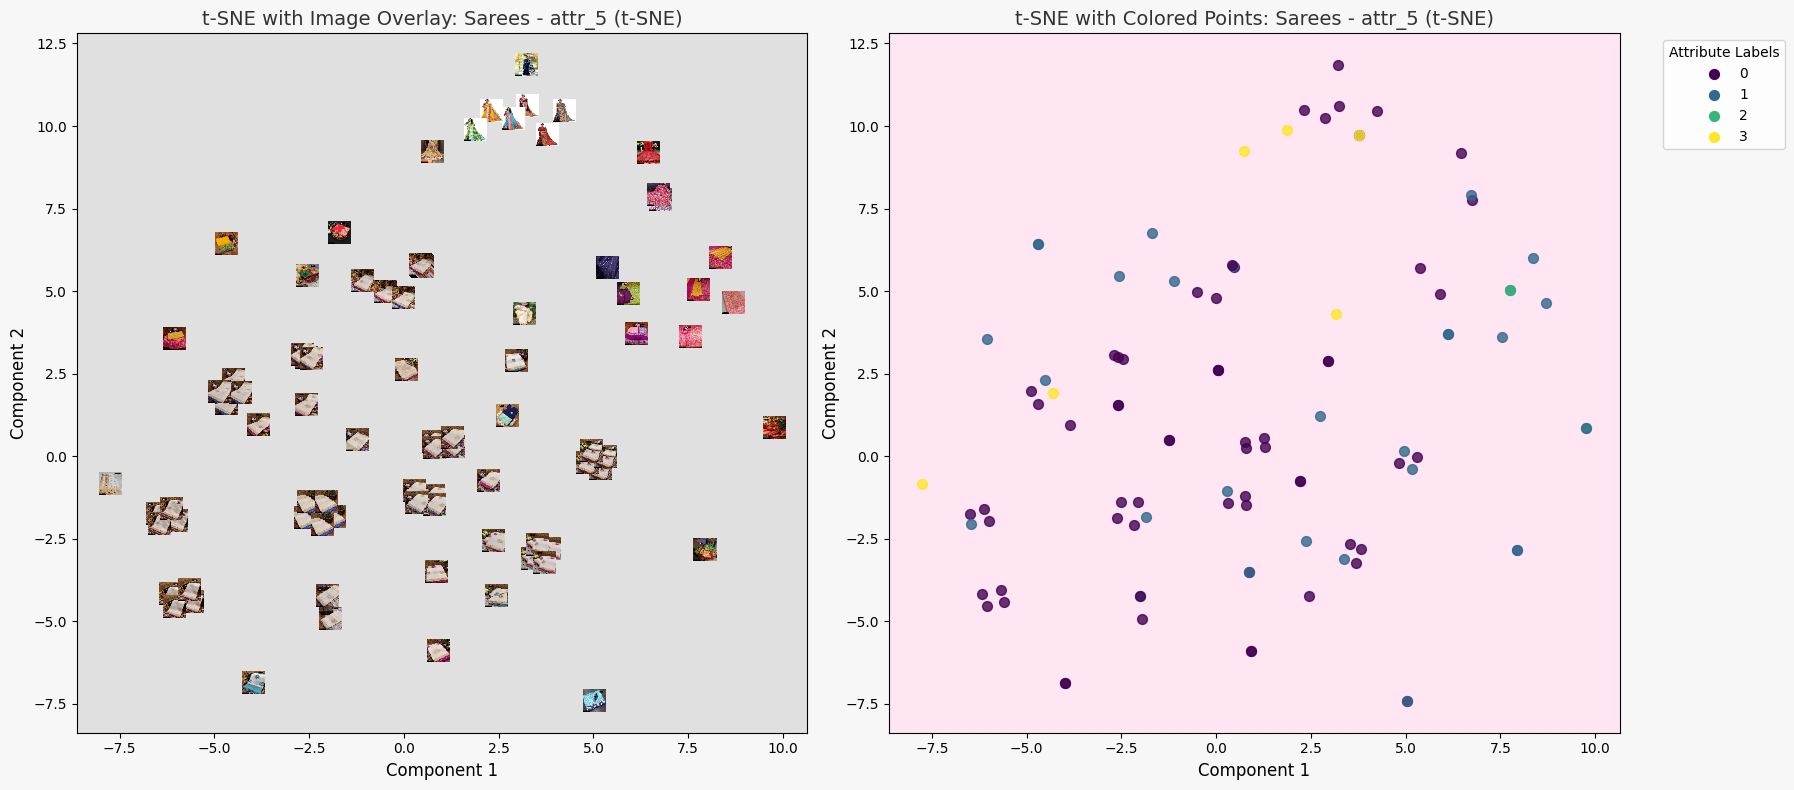

['Kurtis', 'attr', '7', 'attr', '2']
Processing basket: (Kurtis, attr_7, attr_2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1

C:\Users\preet\AppData\Local\Temp\ipykernel_29732\857486119.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(unique_labels))  # Use 'viridis' colormap for better color contrast


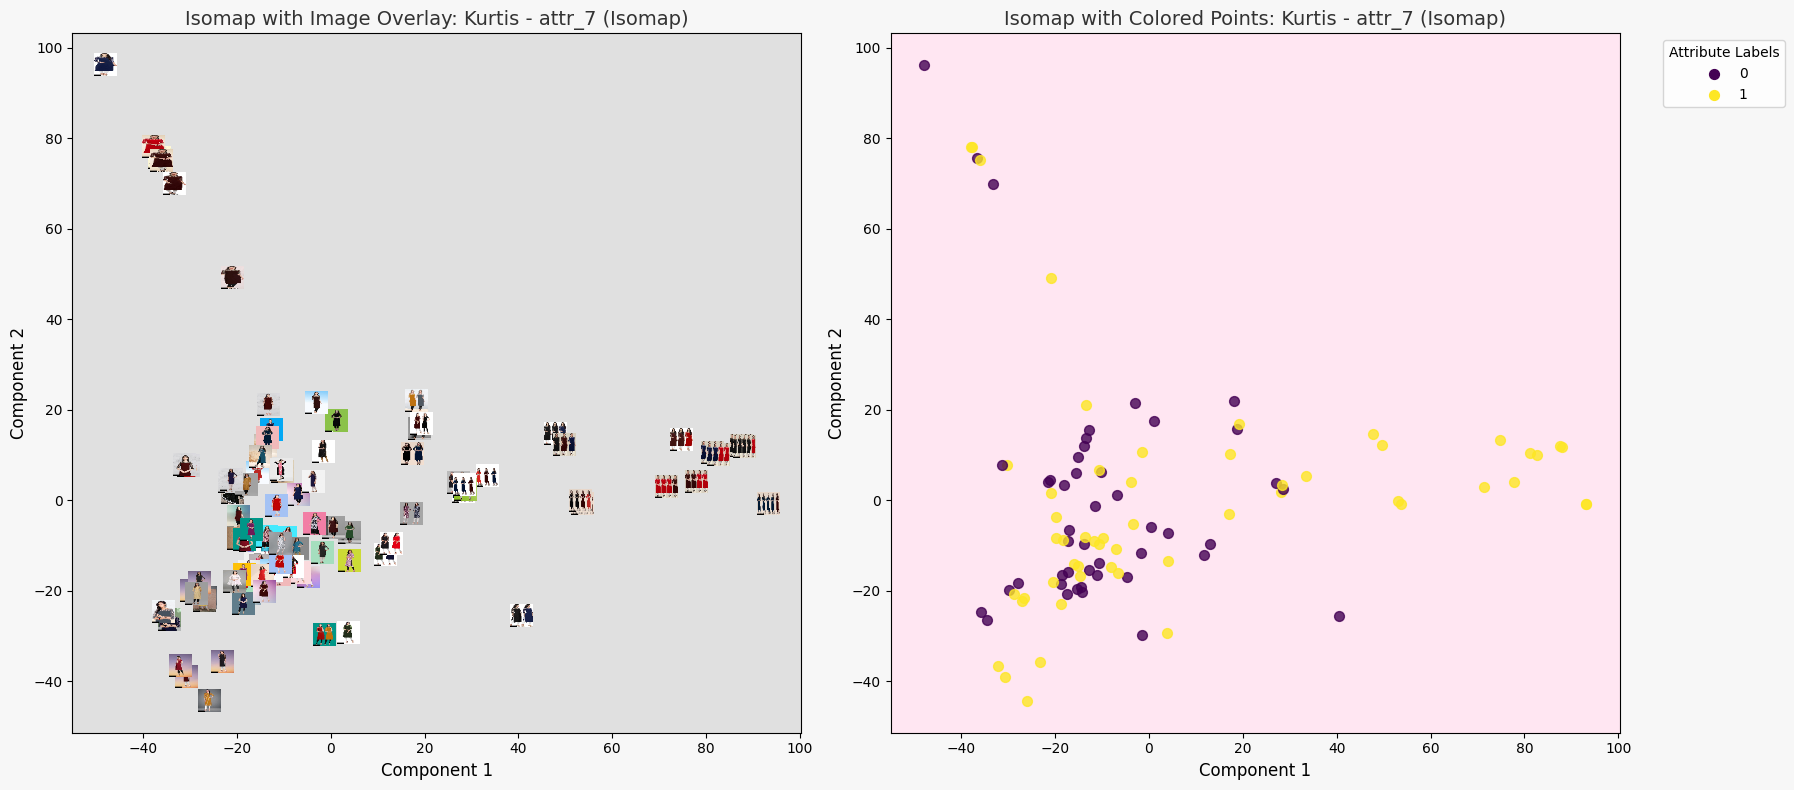

C:\Users\preet\AppData\Local\Temp\ipykernel_29732\857486119.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(unique_labels))  # Use 'viridis' colormap for better color contrast


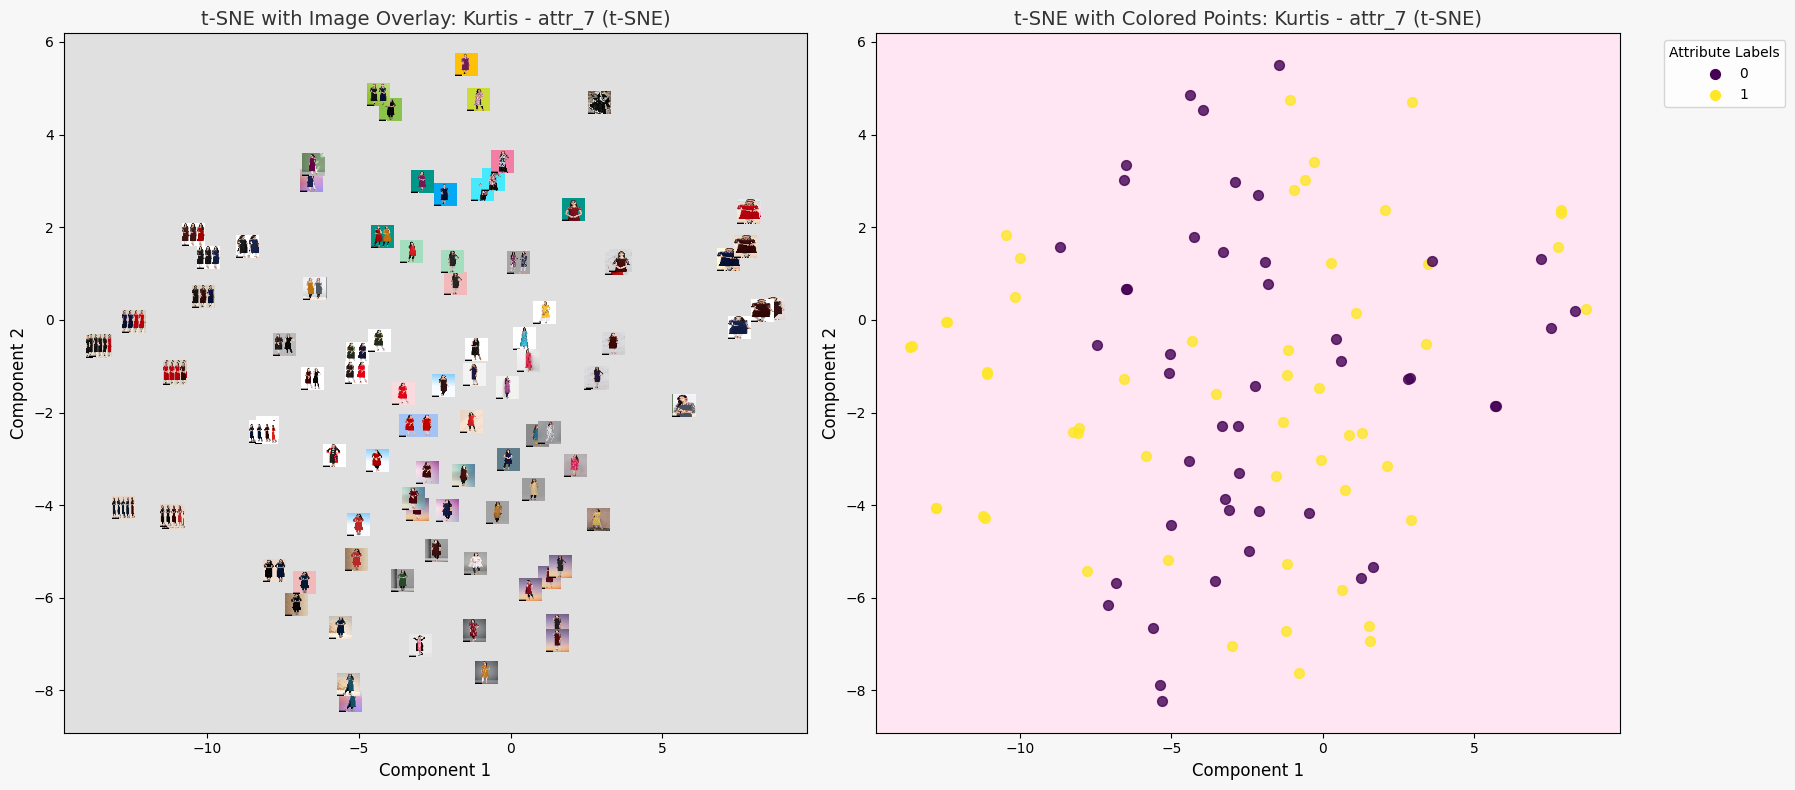

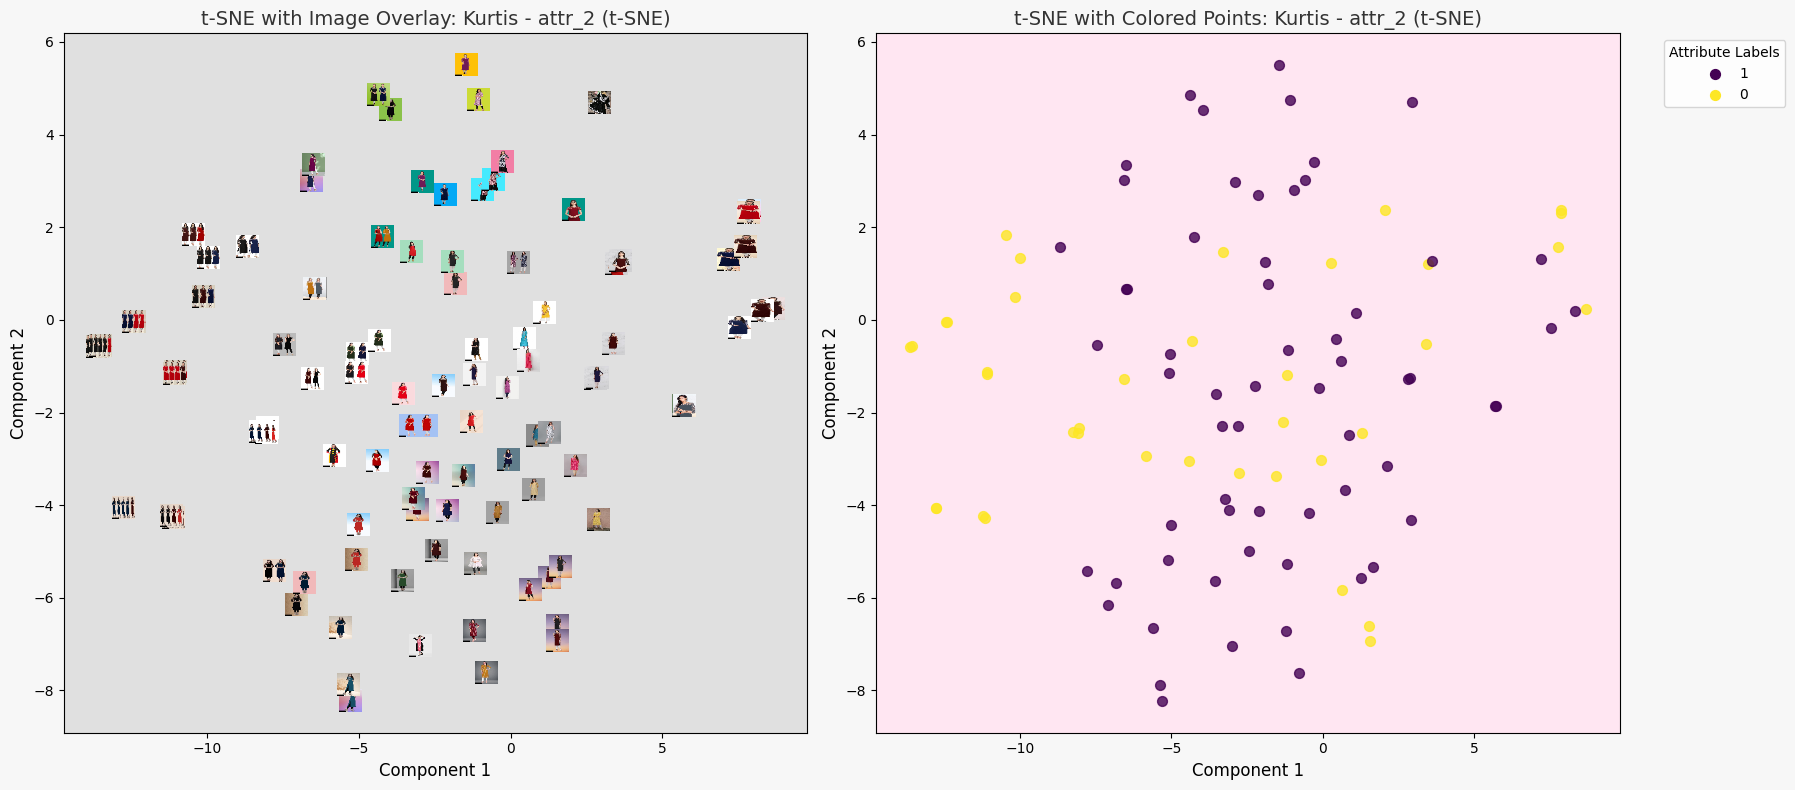

['Women Tshirts', 'attr', '6', 'attr', '7']
Processing basket: (Women Tshirts, attr_6, attr_7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98m

C:\Users\preet\AppData\Local\Temp\ipykernel_29732\857486119.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(unique_labels))  # Use 'viridis' colormap for better color contrast


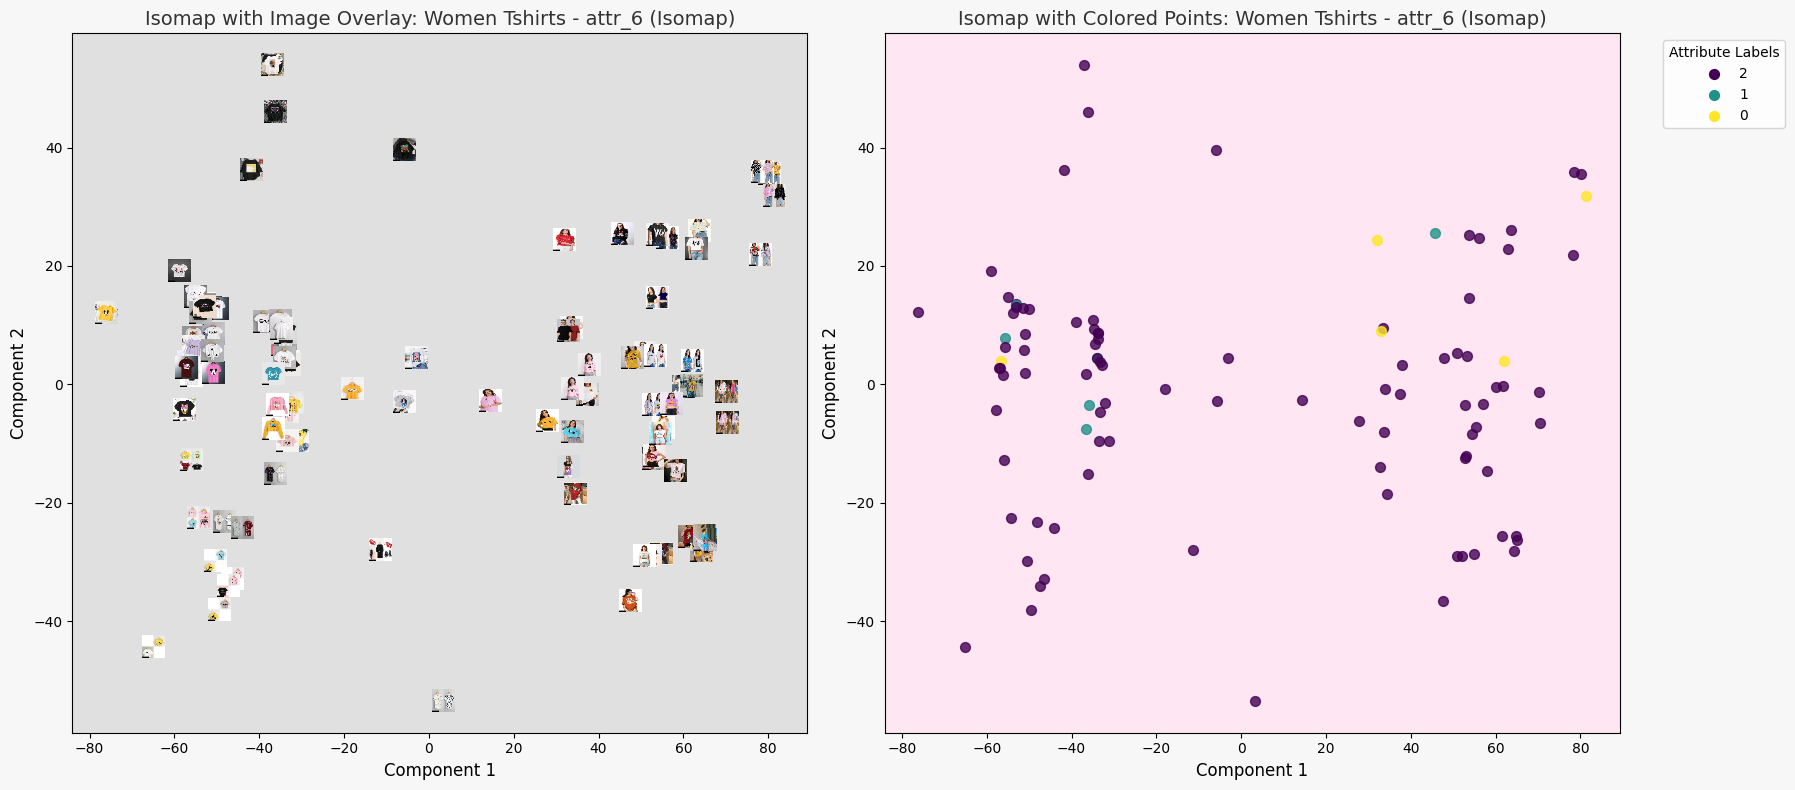

C:\Users\preet\AppData\Local\Temp\ipykernel_29732\857486119.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(unique_labels))  # Use 'viridis' colormap for better color contrast


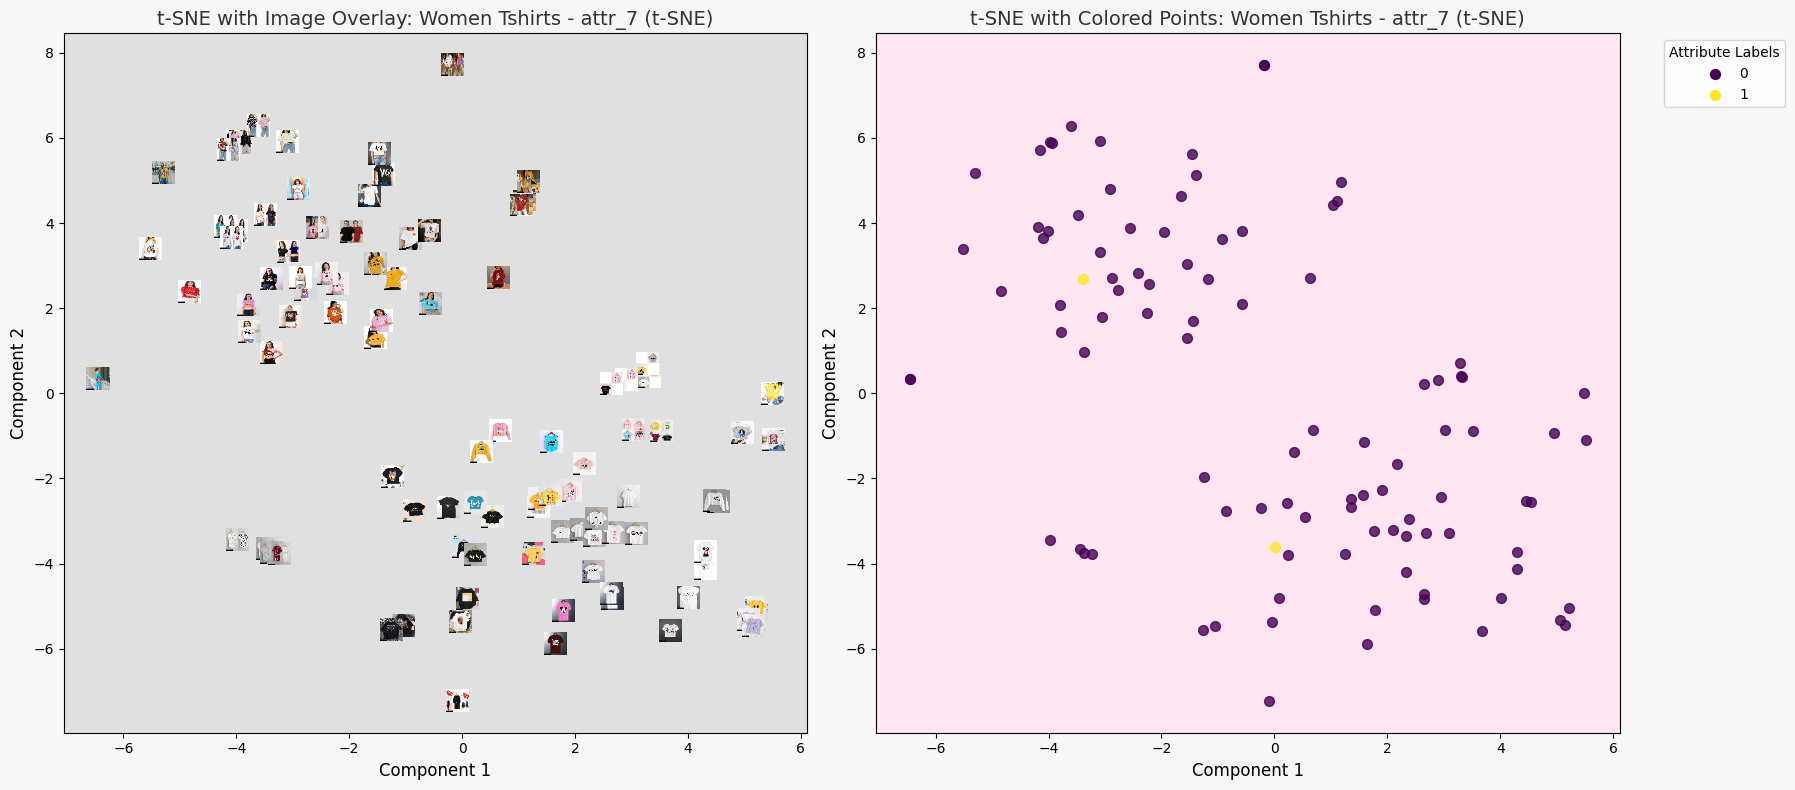

['Women Tops & Tunics', 'attr', '7', 'attr', '3']
Processing basket: (Women Tops & Tunics, attr_7, attr_3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━

C:\Users\preet\AppData\Local\Temp\ipykernel_29732\857486119.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(unique_labels))  # Use 'viridis' colormap for better color contrast


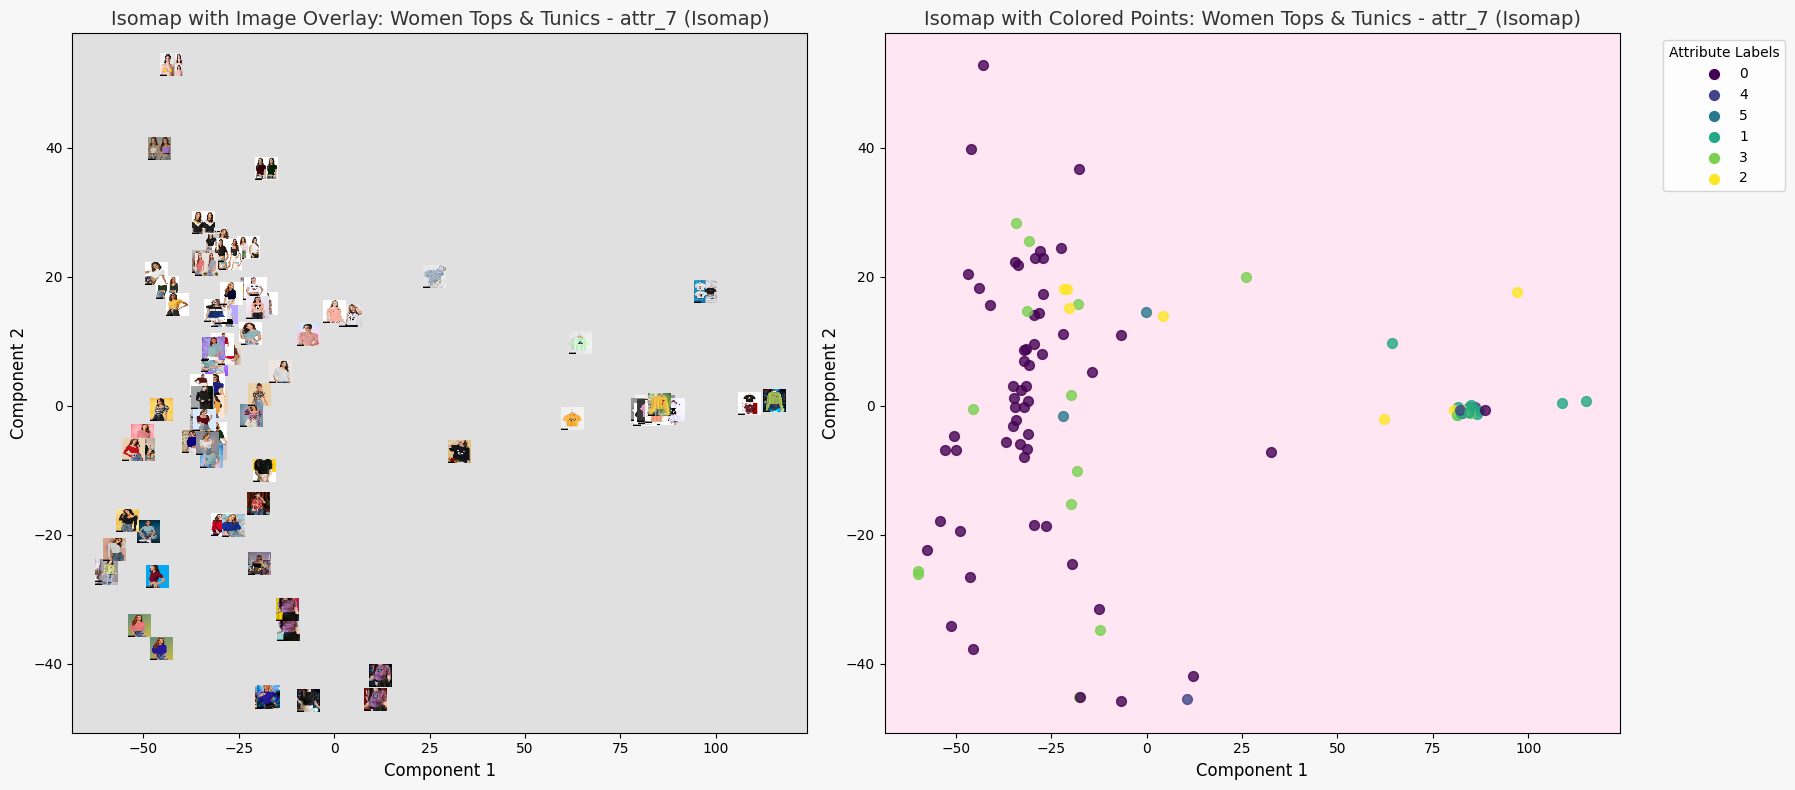

C:\Users\preet\AppData\Local\Temp\ipykernel_29732\857486119.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(unique_labels))  # Use 'viridis' colormap for better color contrast


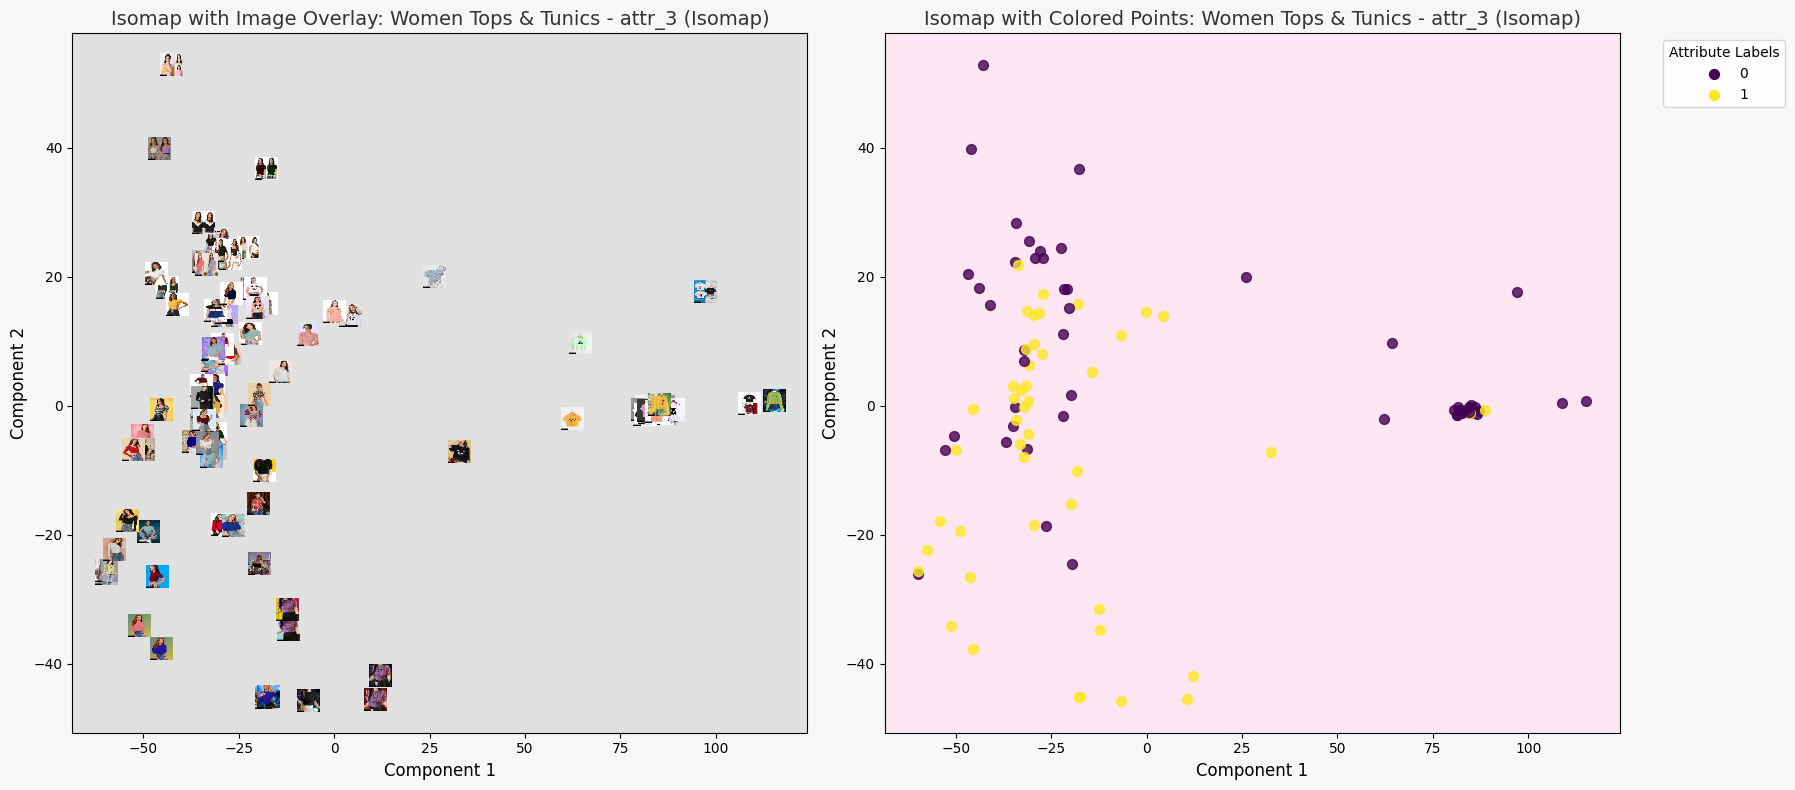

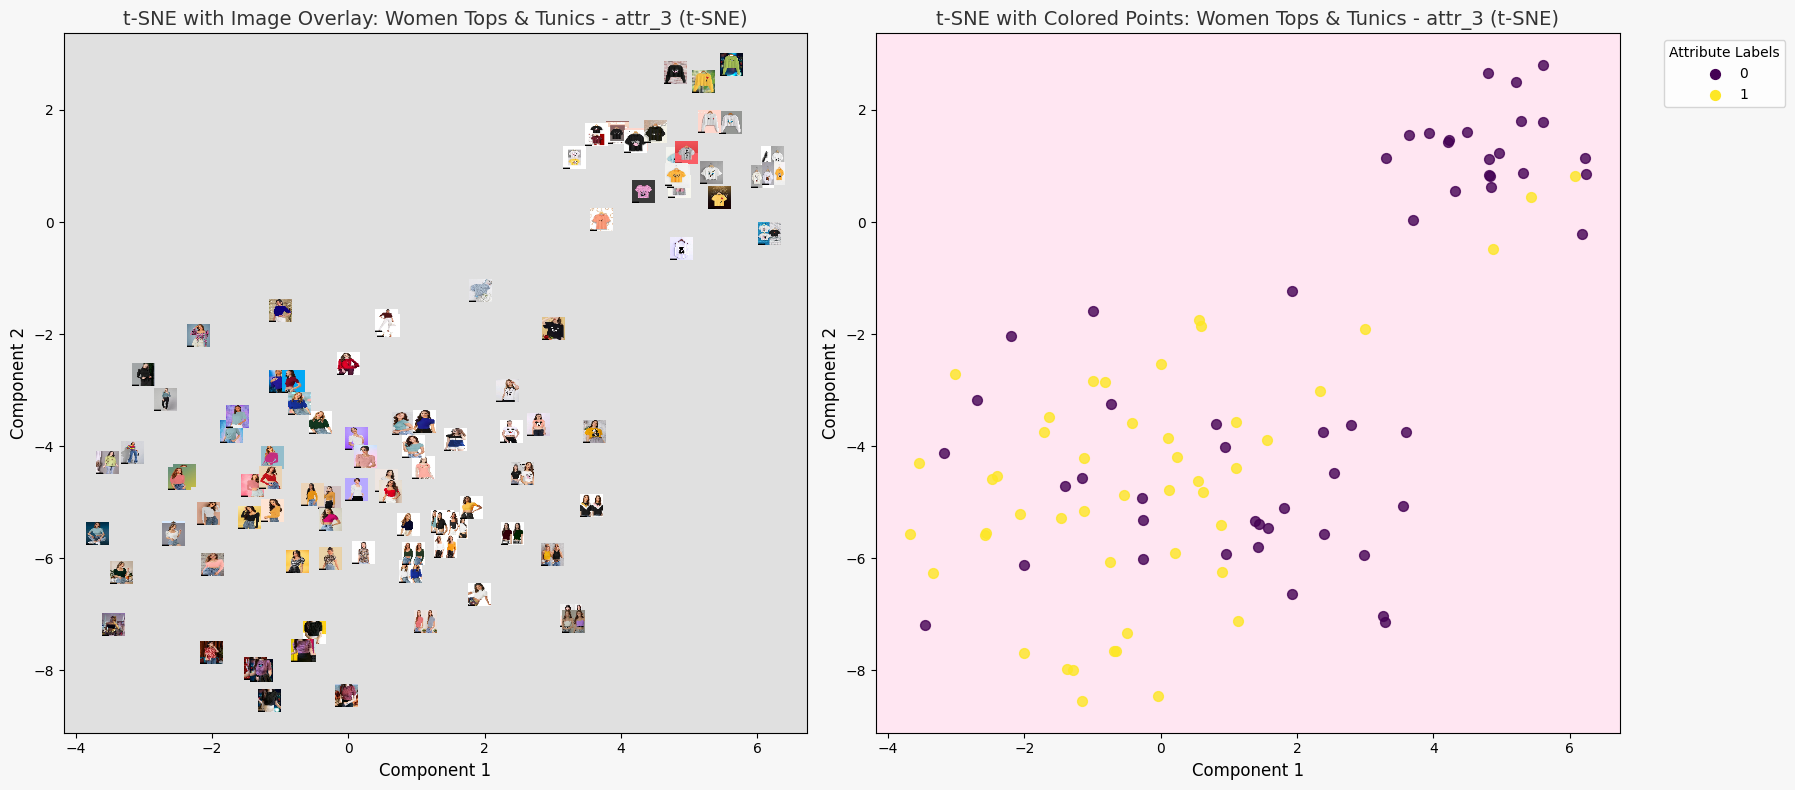

In [27]:
import numpy as np
from sklearn.manifold import Isomap, TSNE

def get_image_path(image_id):
    return rf"C:/Users/preet/Downloads/visual-taxonomy (copy)/train_images/{image_id:06}.jpg"

# process each basket and generate separate visualizations for each attribute using Isomap and t-SNE
for basket_name, samples in basket_samples.items():
    split_name = basket_name.split("_")
    print(split_name)
    category = split_name[0]
    attr1 = "attr_" + split_name[2]
    attr2 = "attr_" + split_name[4] if len(split_name) > 4 else None
    print(f"Processing basket: ({category}, {attr1}, {attr2})" if attr2 else f"Processing basket: ({category}, {attr1})")
    
    image_paths = [get_image_path(img_id) for img_id in samples['id']]
    features_array = np.array([extract_image_features(img_path) for img_path in image_paths])

    # apply Isomap for the first attribute
    isomap = Isomap(n_components=2)
    isomap_results = isomap.fit_transform(features_array)
    plot_embedding_with_images(isomap_results, image_paths, 
                               samples[attr1], f"{category} - {attr1} (Isomap)", "Isomap")
    
    # Apply t-SNE first attribute
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features_array)
    plot_embedding_with_images(tsne_results, image_paths, 
                               samples[attr1], f"{category} - {attr1} (t-SNE)", "t-SNE")

    # apply Isomap for the second attribute
    if attr2:
        plot_embedding_with_images(isomap_results, image_paths, 
                                   samples[attr2], f"{category} - {attr2} (Isomap)", "Isomap")

    # Apply t-SNE second attribute
    if attr2:
        plot_embedding_with_images(tsne_results, image_paths, 
                                   samples[attr2], f"{category} - {attr2} (t-SNE)", "t-SNE")


Task 3:
All polo tshirts are grouped together in Isomap for Men's Tshirt
In the TSNE plot the round neck tshirts are more grouped than in Isomap
There are few long sleeve shirts scattered in Isomap which are grouped in the TSNE plot

In the Isomap for sarees, there seems to be minimal grouping based on border size, however the TSNE plot has some degree of small grouping between the small and big border sarees
The same applies for sarees being grouped based on their occasion too (traditional/party/daily)

In the Isomap for Kurtis, all the default kurtis seem to be grouped, however the solid kurtis are scattered with some mixing into the other group. However, in TSNE for kurti pattern there is no grouping at all for either.
The patterns of Isomap and TSNE are exactly the same for kurtis classified based on cut too.

For Women's Tshirt based on sleeves, in Isomap, the short sleeves are the major class which is scattered with little grouping. In the TSNE, the short sleeves form two distinct groups. The same pattern is observed with the sleeve styling (regular/cuffed) too.

In the Isomap for Wome's tops and Tunics, for pattern the solid is grouped to an extent and the typographic seem to have little grouping too. The same is observed in the TSNE plot too.
In both the Isomap and TSNE for length (crop/regular), there is some degree of grouping for both classes, with closer groups in TSNE, however the cropped class is split into two groups.
